In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
human_data = pd.read_table('path of the dataset(file path)')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [3]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [4]:
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']), axis=1)
human_data = human_data.drop('sequence', axis=1)

In [5]:
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [6]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values      

In [7]:
print(human_texts[2])

atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt

In [8]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

In [9]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)

In [10]:
print(X.shape)

(4380, 232414)


<Axes: >

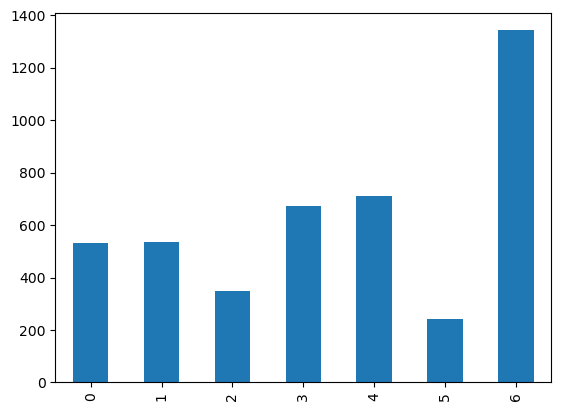

In [11]:
human_data['class'].value_counts().sort_index().plot.bar()

In [12]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [13]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [14]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [15]:
y_pred = classifier.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    1   0    2
1           0  104   0    0    0   0    2
2           0    0  78    0    0   0    0
3           0    0   0  124    0   0    1
4           1    0   0    0  143   0    5
5           0    0   0    0    0  51    0
6           1    0   0    1    0   0  263
accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984


In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def smith_waterman(sequence1, sequence2, match_score, mismatch_score, gap_penalty):
    # Initialize the scoring matrix and traceback matrix with zeros
    m, n = len(sequence1), len(sequence2)
    score_matrix = np.zeros((m + 1, n + 1))
    traceback_matrix = np.zeros((m + 1, n + 1), dtype=int)

    max_score = 0
    max_i, max_j = 0, 0

    # Fill in the scoring and traceback matrices
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if sequence1[i - 1] == sequence2[j - 1]:
                match = score_matrix[i - 1][j - 1] + match_score
            else:
                match = score_matrix[i - 1][j - 1] + mismatch_score

            delete = score_matrix[i - 1][j] + gap_penalty
            insert = score_matrix[i][j - 1] + gap_penalty
            score_matrix[i][j] = max(0, match, delete, insert)

            if score_matrix[i][j] == 0:
                traceback_matrix[i][j] = 0
            elif score_matrix[i][j] == delete:
                traceback_matrix[i][j] = 1
            elif score_matrix[i][j] == insert:
                traceback_matrix[i][j] = 2
            else:
                traceback_matrix[i][j] = 3

            if score_matrix[i][j] > max_score:
                max_score = score_matrix[i][j]
                max_i, max_j = i, j

    # Traceback to find the alignment
    aligned_sequence1, aligned_sequence2 = [], []
    i, j = max_i, max_j

    while i > 0 and j > 0:
        if traceback_matrix[i][j] == 0:
            break
        elif traceback_matrix[i][j] == 3:
            aligned_sequence1.append(sequence1[i - 1])
            aligned_sequence2.append(sequence2[j - 1])
            i -= 1
            j -= 1
        elif traceback_matrix[i][j] == 1:
            i -= 1
        elif traceback_matrix[i][j] == 2:
            j -= 1

    aligned_sequence1 = ''.join(aligned_sequence1[::-1])
    aligned_sequence2 = ''.join(aligned_sequence2[::-1])

    return aligned_sequence1, aligned_sequence2, max_score

# Example usage:
sequence1 = "atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt ccggtt cggttg ggttgg gttggc ttggcg tggcgg ggcggt gcggta cggtag ggtagt gtagtt tagttg agttga gttgac ttgacc tgaccc gacccg acccgc cccgct ccgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttgga ttggaa tggaat ggaatg gaatgc aatgca atgcag tgcagc gcagcc cagcca agccaa gccaat ccaatt caattc aattcg attcga ttcgag tcgagt cgagtg gagtga agtgaa gtgaag tgaaga gaagaa aagaaa agaaat gaaata aaatat aatatc atatcc tatccg atccgt tccgta ccgtat cgtatt gtattt tatttg atttgt tttgtg ttgtgg tgtggc gtggct tggctc ggctct gctctg ctctgt tctgtt ctgtta tgttac gttaca ttacaa tacaat acaatg caatgg aatggt atggtg tggtga ggtgaa gtgaaa tgaaat gaaatc aaatct aatcta atctac tctaca ctacaa tacaac acaacc caacca aaccat accata ccataa cataag ataaga taagaa aagaag agaaga gaagat aagatg agatgc gatgca atgcaa tgcaac gcaaca caacag aacagc acagca cagcat agcatt gcattt catttt attttg ttttga tttgaa ttgaat tgaatt gaattt aatttg atttga tttgaa ttgaat tgaata gaatac aatacc atacca taccag accaga ccagac cagacc agacca gaccaa accaaa ccaaag caaagt aaagtg aagtgg agtgga gtggat tggatg ggatgg gatggt atggtg tggtga ggtgag gtgaga tgagat gagata agataa gataat ataatc taatcc aatcct atcctt tccttc ccttca cttcat ttcatc tcatct catctt atcttt tcttta ctttat tttatg ttatga tatgac atgaca tgacaa gacaaa acaaag caaagg aaagga aaggag aggagg ggagga gaggaa aggaat ggaatt gaattg aattga attgag ttgagc tgagca gagcaa agcaaa gcaaac caaaca aaacaa aacaat acaatt caattt aatttg atttgt tttgta ttgtat tgtatg gtatgt tatgtt atgttg tgttgg gttgga ttggat tggatg ggatgg gatggt atggtg tggtgt ggtgtg gtgtgt tgtgtt gtgttt tgtttg gtttgc tttgca ttgcat tgcatt gcattt catttg atttgt tttgtt ttgttt tgtttt gtttta ttttac tttact ttactg tactgg actgga ctggat tggata ggatac gatact atactg tactgc actgcc ctgcca tgccaa gccaat ccaata caataa aataag ataaga taagaa aagaaa agaaag gaaagt aaagtg aagtgt agtgtt gtgttc tgttcc gttcct ttcctg tcctgg cctggg ctgggt tgggta gggtag ggtaga gtagag tagaga agagat gagata agatac gataca atacat tacata acatat catatg atatgg tatgga atggag tggagt ggagtc gagtca agtcag gtcaga tcagac cagacc agacct gacctt accttt cctttg ctttgt tttgtt ttgttt tgttta gtttaa tttaaa ttaaag taaagc aaagca aagcaa agcaat gcaatg caatga aatgac atgaca tgacag gacaga acagaa cagaag agaaga gaagat aagatg agatgg gatgga atggat tggatt ggattt gatttt attttt tttttg ttttgg tttggc ttggct tggctg ggctgt gctgta ctgtat tgtatg gtatgt tatgtt atgttc tgttca gttcag ttcaga tcagaa cagaag agaagc gaagct aagcta agctaa gctaaa ctaaag taaagg aaaggt aaggtc aggtct ggtctt gtcttg tcttgt cttgtt ttgtta tgttac gttaca ttacat tacatt acattg cattga attgaa ttgaag tgaagc gaagca aagcac agcact gcactc cactcc actccg ctccgc tccgcg ccgcga cgcgac gcgact cgactc gactcc actccc ctccct tccctt cccttt cctttt cttttt ttttta ttttaa tttaaa ttaaaa taaaag aaaagt aaagtg aagtgg agtgga gtggag tggagc ggagcc gagcct agcctt gccttt cctttt cttttc ttttct tttctt ttcttc tcttcc cttcct ttcctg tcctgg cctgga ctggac tggaca ggacac gacact acacta cactat actatg ctatga tatgaa atgaag tgaagt gaagtt aagttt agtttt gttttg ttttgg tttgga ttggat tggatt ggattt gattta atttaa tttaaa ttaaag taaagc aaagcc aagcca agccaa gccaaa ccaaat caaatg aaatgg aatggc atggca tggcaa ggcaaa gcaaag caaagt aaagtt aagttg agttgc gttgca ttgcat tgcatc gcatcc catccg atccgt tccgtg ccgtgg cgtgga gtggaa tggaaa ggaaat gaaatg aaatgg aatggt atggtt tggtta ggttaa gttaaa ttaaat taaata aaatat aatatc atatca tatcat atcatc tcatca catcac atcact tcactg cactgt actgtc ctgtcg tgtcgg gtcggg tcggga cgggat gggatg ggatgt gatgta atgtac tgtacc gtaccc tacccc acccct cccctg ccctgc cctgca ctgcac tgcacg gcacgc cacgcc acgccc cgccct gccctc ccctct cctcta ctctat tctatg ctatga tatgac atgaca tgacaa gacaat acaatg caatgt aatgtg atgtgg tgtgga gtggag tggaga ggagaa gagaaa agaaac gaaact aaactc aactct actctt ctcttt tctttc ctttcc tttcca ttccag tccagg ccaggt caggtt aggttt ggtttt gttttg ttttga tttgag ttgaga tgagat gagata agatag gataga atagaa tagaaa agaaac gaaact aaactg aactgt actgtg ctgtga tgtgaa gtgaag tgaaga gaagaa aagaac agaaca gaacaa aacaac acaacc caacct aacctc acctca cctcag ctcagg tcagga caggat aggatc ggatcc gatcct atcctt tccttt cctttt cttttt ttttta ttttaa tttaat ttaata taataa aataat ataatg taatgc aatgct atgctg tgctgt gctgta ctgtaa tgtaaa gtaaag taaaga aaagaa aagaaa agaaac gaaacg aaacgt aacgtt acgttt cgtttg gtttga tttgat ttgatg tgatga gatgac atgaca tgacag gacaga acagac cagaca agacag gacaga acagaa cagaag agaagg gaagga aaggat aggatt ggattg gattgg attggc ttggct tggctg ggctgc gctgcc ctgcct tgcctt gccttt cctttt ctttta ttttat tttatc ttatca tatcag atcagg tcaggg cagggg aggggg gggggc ggggct gggctt ggcttg gcttgg cttgga ttggac tggact ggactc gactcc actcca ctccag tccagc ccagct cagctt agcttg gcttgg cttggt ttggtt tggttg ggttgc gttgct ttgctg tgctgc gctgcc ctgcca tgccac gccact ccactc cactct actctg ctctgt tctgtt ctgttg tgttga gttgaa ttgaag tgaagc gaagca aagcag agcagc gcagct cagctg agctga gctgaa ctgaaa tgaaag gaaaga aaagaa aagaag agaagc gaagcc aagccc agccca gcccaa cccaag ccaagt caagta aagtac agtaca gtacag tacagt acagta cagtat agtatc gtatcc tatcct atcctc tcctct cctctc ctctcc tctcca ctccag tccaga ccagac cagaca agacat gacatt acattt catttg atttgc tttgca ttgcaa tgcaat gcaatt caattg aattgg attggc ttggca tggcat ggcatg gcatgg catgga atggaa tggaag ggaaga gaagac aagaca agacag gacagc acagcc cagccc agcccc gccccg ccccga cccgat ccgatt cgattt gattta atttac tttact ttactg tactgg actggc ctggct tggctg ggctgc gctgct ctgcta tgctag gctaga ctagaa tagaaa agaaag gaaagg aaaggt aaggtg aggtgg ggtggc gtggca tggcag ggcaga gcagat cagatc agatca gatcat atcata tcatat catatt atattg tattgg attgga ttggaa tggaag ggaagt gaagtg aagtga agtgaa gtgaac tgaaca gaacat aacatt acatta cattat attatg ttatga tatgaa atgaag tgaagt gaagtc aagtcc agtcct gtcctt tccttt cctttt cttttt ttttta ttttaa tttaac ttaact taactc aactct actctg ctctga tctgag ctgagg tgagga gaggaa aggaag ggaagg gaaggc aaggca aggcat ggcatt gcattc cattca attcag ttcagg tcaggc caggct aggctc ggctct gctctg ctctgg tctgga ctggat tggatg ggatga gatgaa atgaag tgaagt gaagtc aagtca agtcat gtcata tcatat catatt atattt tatttt attttc ttttcc tttcct ttcctt tccttg ccttgg cttgga ttggaa tggaaa ggaaac gaaact aaactt aactta acttat cttatg ttatga tatgac atgaca tgacat gacatt acatta cattac attaca ttacaa tacaac acaaca caacag aacagt acagtt cagttc agttcg gttcgt ttcgtg tcgtgc cgtgct gtgctt tgcttc gcttca cttcag ttcagt tcagta cagtag agtagg gtaggt taggta aggtat ggtatg gtatgt tatgta atgtat tgtatt gtattt tattta atttaa tttaat ttaatt taattt aatttc atttcc tttcca ttccaa tccaag ccaagt caagta aagtat agtata gtatat tatatt atattc tattcg attcgg ttcgga tcggaa cggaag ggaaga gaagaa aagaac agaaca gaacac aacaca acacag cacaga acagat cagata agatag gatagc atagcg tagcgt agcgtg gcgtgg cgtggt gtggtg tggtga ggtgat gtgatc tgatct gatctt atcttc tcttct cttctc ttctct tctctg ctctgg tctgga ctggag tggaga ggagaa gagaag agaagg gaagga aaggat aggatc ggatca gatcag atcaga tcagat cagatg agatga gatgaa atgaac tgaact gaactt aactta acttac cttacg ttacgc tacgca acgcag cgcagg gcaggg cagggt agggtt gggtta ggttac gttaca ttacat tacata acatat catata atatat tatatt atattt tatttt attttc ttttca tttcac ttcaca tcacaa cacaag acaagg caaggc aaggct aggctc ggctcc gctcct ctcctt tccttc ccttct cttctc ttctcc tctcct ctcctg tcctga cctgaa ctgaaa tgaaaa gaaaaa aaaaag aaaagc aaagcc aagccg agccga gccgag ccgagg cgagga gaggag aggagg ggagga gaggag aggaga ggagag gagagt agagtg gagtga agtgag gtgaga tgagag gagagg agaggc gaggct aggctt ggcttc gcttct cttctg ttctga tctgag ctgagg tgaggg gaggga agggaa gggaac ggaact gaactc aactct actcta ctctat tctatt ctattt tatttg atttgt tttgtt ttgttt tgtttg gtttga tttgat ttgatg tgatgt gatgtt atgttc tgttct gttctc ttctcc tctccg ctccgc tccgcg ccgcgc cgcgca gcgcag cgcaga gcagat cagatc agatcg gatcga atcgaa tcgaac cgaact gaacta aactac actact ctactg tactgc actgct ctgctg tgctgc gctgcc ctgccc tgccca gcccat cccatg ccatgg catggt atggtc tggtct ggtctt gtcttg tcttga cttgaa ttgaac tgaact gaactg aactga actgag ctgaga tgagag gagagt agagtc gagtcc agtccc gtccca tcccat cccatt ccattt catttc atttct tttcta ttctag tctaga ctagat tagatc agatca gatcat atcatc tcatcg catcga atcgat tcgatt cgattt gatttt attttc ttttct tttctt ttcttc tcttcc cttcct ttccta tcctat cctatt ctatta tattac attact ttactt tacttg acttgt cttgtc ttgtct tgtctc gtctct tctctg ctctgc tctgcc ctgcca tgccac gccacc ccacca caccag accaga ccagaa cagaaa agaaat gaaatg aaatga aatgag atgaga tgagaa gagaat agaatt gaattc aattcc attcca ttccaa tccaaa ccaaag caaaga aaagaa aagaat agaatg gaatgg aatggg atggga tgggat gggata ggatag gataga atagaa tagaaa agaaaa gaaaaa aaaaac aaaaca aaacat aacatc acatct catctc atctcc tctcct ctcctg tcctga cctgag ctgaga tgagag gagaga agagag gagaga agagac gagacg agacgt gacgtt acgttt cgtttg gtttga tttgag ttgagg tgagga gaggat aggatt ggattc gattcc attcca ttccaa tccaat ccaatc caatct aatctg atctga tctgat ctgata tgatac gatacc ataccc taccca acccaa cccaaa ccaaag caaaga aaagag aagaga agagat gagatt agattc gattct attctc ttctct tctctg ctctgg tctggc ctggcg tggcga ggcgac gcgacc cgacca gaccaa accaaa ccaaaa caaaag aaaaga aaagaa aagaag agaagc gaagcc aagcct agcctt gccttc ccttca cttcag ttcagt tcagtg cagtga agtgat gtgatg tgatgg gatgga atggaa tggaat ggaata gaataa aataac ataact taactt aacttc acttca cttcag ttcagt tcagtt cagtta agttaa gttaag ttaaga taagaa aagaat agaatt gaattc aattcc attcct ttcctg tcctgg cctggt ctggtt tggttt ggttta gtttaa tttaag ttaaga taagat aagatt agattt gatttt atttta ttttac tttaca ttacag tacagg acagga caggaa aggaat ggaata gaatac aatacg atacgt tacgtt acgttg cgttga gttgaa ttgaac tgaaca gaacat aacatc acatca catcag atcagg tcaggt caggtt aggttg ggttga gttgat ttgatg tgatga gatgat atgatg tgatgc gatgca atgcaa tgcaat gcaatg caatga aatgat atgatg tgatgg gatggc atggca tggcaa ggcaaa gcaaat caaatg aaatgc aatgca atgcag tgcagc gcagcc cagccc agccca gcccag cccaga ccagaa cagaaa agaaat gaaatt aaattt aatttc atttcc tttccc ttccct tccctt cccttc ccttca cttcaa ttcaat tcaata caatac aatact atactc tactcc actcct ctccta tcctaa cctaaa ctaaaa taaaac aaaacc aaacca aaccaa accaaa ccaaag caaaga aaagaa aagaag agaagg gaagga aaggat aggata ggatat gatatt atatta tattac attact ttacta tactac actacc ctaccg taccgt accgtc ccgtca cgtcaa gtcaag tcaagt caagtc aagtct agtctt gtcttt tctttg ctttga tttgaa ttgaac tgaacg gaacgc aacgcc acgcca cgccat gccatt ccatta cattac attacc ttaccc taccca acccag cccagg ccaggc caggcc aggccg ggccgg gccggg ccgggc cgggct gggctg ggctga gctgac ctgact tgactg gactgg actggc ctggct tggctg ggctga gctgag ctgagc tgagcc gagcca agccat gccatt ccatta cattac attact ttactg tactgg actgga ctggat tggatg ggatgc gatgcc atgccc tgccca gcccaa cccaag ccaagt caagtg aagtgg agtgga gtggat tggatc ggatca gatcaa atcaat tcaatg caatgc aatgcc atgcca tgccac gccact ccactg cactga actgac ctgacc tgaccc gaccct accctt cccttc ccttct cttctg ttctgc tctgcc ctgccc tgcccg gcccgc cccgca ccgcac cgcacg gcacgc cacgct acgctg cgctga gctgac ctgacc tgaccc gaccca acccac cccact ccacta cactac actaca ctacaa tacaag acaagt caagtc aagtca agtcag gtcagc tcagct cagctg agctgt gctgtc ctgtca tgtcaa gtcaaa tcaaag caaagc aaagct aagctt agctta gcttag"
sequence2 = "gggcgc "
match_score = 2
mismatch_score = -1
gap_penalty = -2

aligned_sequence1, aligned_sequence2, max_score = smith_waterman(sequence1, sequence2, match_score, mismatch_score, gap_penalty)

print("Aligned Sequence 1:", aligned_sequence1)
print("Aligned Sequence 2:", aligned_sequence2)
print("Alignment Score:",max_score)


Aligned Sequence 1: gggcgc 
Aligned Sequence 2: gggcgc 
Alignment Score: 14.0


In [18]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


C:\Users\Chaithra.k\anaconda\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Alignment Score: 368.0


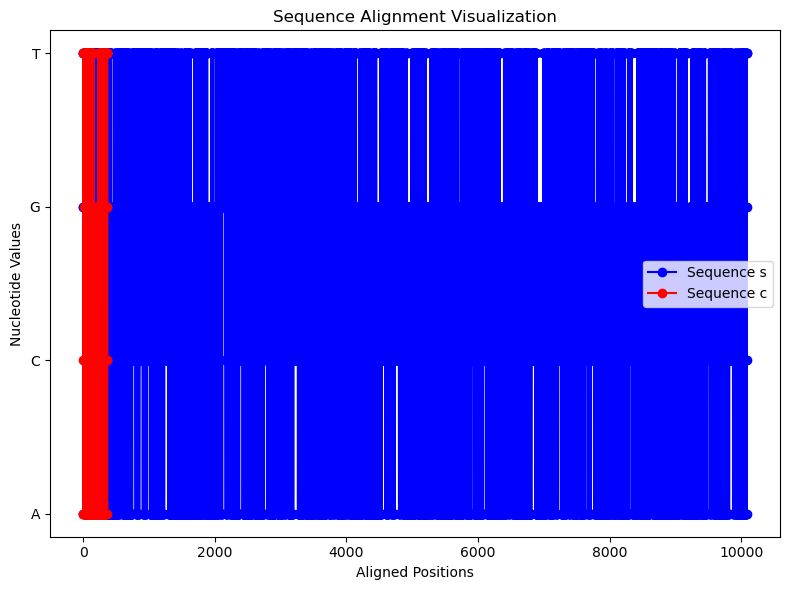

In [19]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import matplotlib.pyplot as plt

# Sequences
s1 = "atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggcatt gcattt catttg atttgg tttggg ttgggc tgggcg gggcgc ggcgct gcgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttggc ttggca tggcag ggcagt gcagtg cagtga agtgat gtgatg tgatga gatgat atgatt tgattg gattgc attgcc ttgcct tgcctt gccttt cctttc ctttct tttctg ttctgt tctgtt ctgttc tgttca gttcag ttcagt tcagtg cagtgt agtgtc gtgtct tgtctg gtctga tctgag ctgagt tgagtg gagtgc agtgct gtgcta tgctat gctatg ctatga tatgaa atgaag tgaaga gaagat aagatt agattg gattgc attgca ttgcac tgcaca gcacac cacaca acacag cacaga acagag cagagg agaggt gaggtc aggtcc ggtcca gtccag tccaga ccagat cagatg agatgc gatgca atgcat tgcatt gcattc cattcc attccg ttccgt tccgtt ccgttt cgtttt gttttg ttttga tttgag ttgaga tgagaa gagaat agaatg gaatgt aatgtc atgtca tgtcaa gtcaat tcaatg caatgg aatgga atggat tggata ggatac gataca atacac tacacc acacca caccaa accaac ccaact caactg aactgc actgct ctgctg tgctgc gctgct ctgctt tgcttt gctttg ctttgg tttgga ttggat tggatt ggattt gatttc atttca tttcac ttcacc tcaccg caccgg accggt ccggtt cggttg ggttgg gttggc ttggcg tggcgg ggcggt gcggta cggtag ggtagt gtagtt tagttg agttga gttgac ttgacc tgaccc gacccg acccgc cccgct ccgctg cgctgt gctgtt ctgttt tgtttg gtttgg tttgga ttggaa tggaat ggaatg gaatgc aatgca atgcag tgcagc gcagcc cagcca agccaa gccaat ccaatt caattc aattcg attcga ttcgag tcgagt cgagtg gagtga agtgaa gtgaag tgaaga gaagaa aagaaa agaaat gaaata aaatat aatatc atatcc tatccg atccgt tccgta ccgtat cgtatt gtattt tatttg atttgt tttgtg ttgtgg tgtggc gtggct tggctc ggctct gctctg ctctgt tctgtt ctgtta tgttac gttaca ttacaa tacaat acaatg caatgg aatggt atggtg tggtga ggtgaa gtgaaa tgaaat gaaatc aaatct aatcta atctac tctaca ctacaa tacaac acaacc caacca aaccat accata ccataa cataag ataaga taagaa aagaag agaaga gaagat aagatg agatgc gatgca atgcaa tgcaac gcaaca caacag aacagc acagca cagcat agcatt gcattt catttt attttg ttttga tttgaa ttgaat tgaatt gaattt aatttg atttga tttgaa ttgaat tgaata gaatac aatacc atacca taccag accaga ccagac cagacc agacca gaccaa accaaa ccaaag caaagt aaagtg aagtgg agtgga gtggat tggatg ggatgg gatggt atggtg tggtga ggtgag gtgaga tgagat gagata agataa gataat ataatc taatcc aatcct atcctt tccttc ccttca cttcat ttcatc tcatct catctt atcttt tcttta ctttat tttatg ttatga tatgac atgaca tgacaa gacaaa acaaag caaagg aaagga aaggag aggagg ggagga gaggaa aggaat ggaatt gaattg aattga attgag ttgagc tgagca gagcaa agcaaa gcaaac caaaca aaacaa aacaat acaatt caattt aatttg atttgt tttgta ttgtat tgtatg gtatgt tatgtt atgttg tgttgg gttgga ttggat tggatg ggatgg gatggt atggtg tggtgt ggtgtg gtgtgt tgtgtt gtgttt tgtttg gtttgc tttgca ttgcat tgcatt gcattt catttg atttgt tttgtt ttgttt tgtttt gtttta ttttac tttact ttactg tactgg actgga ctggat tggata ggatac gatact atactg tactgc actgcc ctgcca tgccaa gccaat ccaata caataa aataag ataaga taagaa aagaaa agaaag gaaagt aaagtg aagtgt agtgtt gtgttc tgttcc gttcct ttcctg tcctgg cctggg ctgggt tgggta gggtag ggtaga gtagag tagaga agagat gagata agatac gataca atacat tacata acatat catatg atatgg tatgga atggag tggagt ggagtc gagtca agtcag gtcaga tcagac cagacc agacct gacctt accttt cctttg ctttgt tttgtt ttgttt tgttta gtttaa tttaaa ttaaag taaagc aaagca aagcaa agcaat gcaatg caatga aatgac atgaca tgacag gacaga acagaa cagaag agaaga gaagat aagatg agatgg gatgga atggat tggatt ggattt gatttt attttt tttttg ttttgg tttggc ttggct tggctg ggctgt gctgta ctgtat tgtatg gtatgt tatgtt atgttc tgttca gttcag ttcaga tcagaa cagaag agaagc gaagct aagcta agctaa gctaaa ctaaag taaagg aaaggt aaggtc aggtct ggtctt gtcttg tcttgt cttgtt ttgtta tgttac gttaca ttacat tacatt acattg cattga attgaa ttgaag tgaagc gaagca aagcac agcact gcactc cactcc actccg ctccgc tccgcg ccgcga cgcgac gcgact cgactc gactcc actccc ctccct tccctt cccttt cctttt cttttt ttttta ttttaa tttaaa ttaaaa taaaag aaaagt aaagtg aagtgg agtgga gtggag tggagc ggagcc gagcct agcctt gccttt cctttt cttttc ttttct tttctt ttcttc tcttcc cttcct ttcctg tcctgg cctgga ctggac tggaca ggacac gacact acacta cactat actatg ctatga tatgaa atgaag tgaagt gaagtt aagttt agtttt gttttg ttttgg tttgga ttggat tggatt ggattt gattta atttaa tttaaa ttaaag taaagc aaagcc aagcca agccaa gccaaa ccaaat caaatg aaatgg aatggc atggca tggcaa ggcaaa gcaaag caaagt aaagtt aagttg agttgc gttgca ttgcat tgcatc gcatcc catccg atccgt tccgtg ccgtgg cgtgga gtggaa tggaaa ggaaat gaaatg aaatgg aatggt atggtt tggtta ggttaa gttaaa ttaaat taaata aaatat aatatc atatca tatcat atcatc tcatca catcac atcact tcactg cactgt actgtc ctgtcg tgtcgg gtcggg tcggga cgggat gggatg ggatgt gatgta atgtac tgtacc gtaccc tacccc acccct cccctg ccctgc cctgca ctgcac tgcacg gcacgc cacgcc acgccc cgccct gccctc ccctct cctcta ctctat tctatg ctatga tatgac atgaca tgacaa gacaat acaatg caatgt aatgtg atgtgg tgtgga gtggag tggaga ggagaa gagaaa agaaac gaaact aaactc aactct actctt ctcttt tctttc ctttcc tttcca ttccag tccagg ccaggt caggtt aggttt ggtttt gttttg ttttga tttgag ttgaga tgagat gagata agatag gataga atagaa tagaaa agaaac gaaact aaactg aactgt actgtg ctgtga tgtgaa gtgaag tgaaga gaagaa aagaac agaaca gaacaa aacaac acaacc caacct aacctc acctca cctcag ctcagg tcagga caggat aggatc ggatcc gatcct atcctt tccttt cctttt cttttt ttttta ttttaa tttaat ttaata taataa aataat ataatg taatgc aatgct atgctg tgctgt gctgta ctgtaa tgtaaa gtaaag taaaga aaagaa aagaaa agaaac gaaacg aaacgt aacgtt acgttt cgtttg gtttga tttgat ttgatg tgatga gatgac atgaca tgacag gacaga acagac cagaca agacag gacaga acagaa cagaag agaagg gaagga aaggat aggatt ggattg gattgg attggc ttggct tggctg ggctgc gctgcc ctgcct tgcctt gccttt cctttt ctttta ttttat tttatc ttatca tatcag atcagg tcaggg cagggg aggggg gggggc ggggct gggctt ggcttg gcttgg cttgga ttggac tggact ggactc gactcc actcca ctccag tccagc ccagct cagctt agcttg gcttgg cttggt ttggtt tggttg ggttgc gttgct ttgctg tgctgc gctgcc ctgcca tgccac gccact ccactc cactct actctg ctctgt tctgtt ctgttg tgttga gttgaa ttgaag tgaagc gaagca aagcag agcagc gcagct cagctg agctga gctgaa ctgaaa tgaaag gaaaga aaagaa aagaag agaagc gaagcc aagccc agccca gcccaa cccaag ccaagt caagta aagtac agtaca gtacag tacagt acagta cagtat agtatc gtatcc tatcct atcctc tcctct cctctc ctctcc tctcca ctccag tccaga ccagac cagaca agacat gacatt acattt catttg atttgc tttgca ttgcaa tgcaat gcaatt caattg aattgg attggc ttggca tggcat ggcatg gcatgg catgga atggaa tggaag ggaaga gaagac aagaca agacag gacagc acagcc cagccc agcccc gccccg ccccga cccgat ccgatt cgattt gattta atttac tttact ttactg tactgg actggc ctggct tggctg ggctgc gctgct ctgcta tgctag gctaga ctagaa tagaaa agaaag gaaagg aaaggt aaggtg aggtgg ggtggc gtggca tggcag ggcaga gcagat cagatc agatca gatcat atcata tcatat catatt atattg tattgg attgga ttggaa tggaag ggaagt gaagtg aagtga agtgaa gtgaac tgaaca gaacat aacatt acatta cattat attatg ttatga tatgaa atgaag tgaagt gaagtc aagtcc agtcct gtcctt tccttt cctttt cttttt ttttta ttttaa tttaac ttaact taactc aactct actctg ctctga tctgag ctgagg tgagga gaggaa aggaag ggaagg gaaggc aaggca aggcat ggcatt gcattc cattca attcag ttcagg tcaggc caggct aggctc ggctct gctctg ctctgg tctgga ctggat tggatg ggatga gatgaa atgaag tgaagt gaagtc aagtca agtcat gtcata tcatat catatt atattt tatttt attttc ttttcc tttcct ttcctt tccttg ccttgg cttgga ttggaa tggaaa ggaaac gaaact aaactt aactta acttat cttatg ttatga tatgac atgaca tgacat gacatt acatta cattac attaca ttacaa tacaac acaaca caacag aacagt acagtt cagttc agttcg gttcgt ttcgtg tcgtgc cgtgct gtgctt tgcttc gcttca cttcag ttcagt tcagta cagtag agtagg gtaggt taggta aggtat ggtatg gtatgt tatgta atgtat tgtatt gtattt tattta atttaa tttaat ttaatt taattt aatttc atttcc tttcca ttccaa tccaag ccaagt caagta aagtat agtata gtatat tatatt atattc tattcg attcgg ttcgga tcggaa cggaag ggaaga gaagaa aagaac agaaca gaacac aacaca acacag cacaga acagat cagata agatag gatagc atagcg tagcgt agcgtg gcgtgg cgtggt gtggtg tggtga ggtgat gtgatc tgatct gatctt atcttc tcttct cttctc ttctct tctctg ctctgg tctgga ctggag tggaga ggagaa gagaag agaagg gaagga aaggat aggatc ggatca gatcag atcaga tcagat cagatg agatga gatgaa atgaac tgaact gaactt aactta acttac cttacg ttacgc tacgca acgcag cgcagg gcaggg cagggt agggtt gggtta ggttac gttaca ttacat tacata acatat catata atatat tatatt atattt tatttt attttc ttttca tttcac ttcaca tcacaa cacaag acaagg caaggc aaggct aggctc ggctcc gctcct ctcctt tccttc ccttct cttctc ttctcc tctcct ctcctg tcctga cctgaa ctgaaa tgaaaa gaaaaa aaaaag aaaagc aaagcc aagccg agccga gccgag ccgagg cgagga gaggag aggagg ggagga gaggag aggaga ggagag gagagt agagtg gagtga agtgag gtgaga tgagag gagagg agaggc gaggct aggctt ggcttc gcttct cttctg ttctga tctgag ctgagg tgaggg gaggga agggaa gggaac ggaact gaactc aactct actcta ctctat tctatt ctattt tatttg atttgt tttgtt ttgttt tgtttg gtttga tttgat ttgatg tgatgt gatgtt atgttc tgttct gttctc ttctcc tctccg ctccgc tccgcg ccgcgc cgcgca gcgcag cgcaga gcagat cagatc agatcg gatcga atcgaa tcgaac cgaact gaacta aactac actact ctactg tactgc actgct ctgctg tgctgc gctgcc ctgccc tgccca gcccat cccatg ccatgg catggt atggtc tggtct ggtctt gtcttg tcttga cttgaa ttgaac tgaact gaactg aactga actgag ctgaga tgagag gagagt agagtc gagtcc agtccc gtccca tcccat cccatt ccattt catttc atttct tttcta ttctag tctaga ctagat tagatc agatca gatcat atcatc tcatcg catcga atcgat tcgatt cgattt gatttt attttc ttttct tttctt ttcttc tcttcc cttcct ttccta tcctat cctatt ctatta tattac attact ttactt tacttg acttgt cttgtc ttgtct tgtctc gtctct tctctg ctctgc tctgcc ctgcca tgccac gccacc ccacca caccag accaga ccagaa cagaaa agaaat gaaatg aaatga aatgag atgaga tgagaa gagaat agaatt gaattc aattcc attcca ttccaa tccaaa ccaaag caaaga aaagaa aagaat agaatg gaatgg aatggg atggga tgggat gggata ggatag gataga atagaa tagaaa agaaaa gaaaaa aaaaac aaaaca aaacat aacatc acatct catctc atctcc tctcct ctcctg tcctga cctgag ctgaga tgagag gagaga agagag gagaga agagac gagacg agacgt gacgtt acgttt cgtttg gtttga tttgag ttgagg tgagga gaggat aggatt ggattc gattcc attcca ttccaa tccaat ccaatc caatct aatctg atctga tctgat ctgata tgatac gatacc ataccc taccca acccaa cccaaa ccaaag caaaga aaagag aagaga agagat gagatt agattc gattct attctc ttctct tctctg ctctgg tctggc ctggcg tggcga ggcgac gcgacc cgacca gaccaa accaaa ccaaaa caaaag aaaaga aaagaa aagaag agaagc gaagcc aagcct agcctt gccttc ccttca cttcag ttcagt tcagtg cagtga agtgat gtgatg tgatgg gatgga atggaa tggaat ggaata gaataa aataac ataact taactt aacttc acttca cttcag ttcagt tcagtt cagtta agttaa gttaag ttaaga taagaa aagaat agaatt gaattc aattcc attcct ttcctg tcctgg cctggt ctggtt tggttt ggttta gtttaa tttaag ttaaga taagat aagatt agattt gatttt atttta ttttac tttaca ttacag tacagg acagga caggaa aggaat ggaata gaatac aatacg atacgt tacgtt acgttg cgttga gttgaa ttgaac tgaaca gaacat aacatc acatca catcag atcagg tcaggt caggtt aggttg ggttga gttgat ttgatg tgatga gatgat atgatg tgatgc gatgca atgcaa tgcaat gcaatg caatga aatgat atgatg tgatgg gatggc atggca tggcaa ggcaaa gcaaat caaatg aaatgc aatgca atgcag tgcagc gcagcc cagccc agccca gcccag cccaga ccagaa cagaaa agaaat gaaatt aaattt aatttc atttcc tttccc ttccct tccctt cccttc ccttca cttcaa ttcaat tcaata caatac aatact atactc tactcc actcct ctccta tcctaa cctaaa ctaaaa taaaac aaaacc aaacca aaccaa accaaa ccaaag caaaga aaagaa aagaag agaagg gaagga aaggat aggata ggatat gatatt atatta tattac attact ttacta tactac actacc ctaccg taccgt accgtc ccgtca cgtcaa gtcaag tcaagt caagtc aagtct agtctt gtcttt tctttg ctttga tttgaa ttgaac tgaacg gaacgc aacgcc acgcca cgccat gccatt ccatta cattac attacc ttaccc taccca acccag cccagg ccaggc caggcc aggccg ggccgg gccggg ccgggc cgggct gggctg ggctga gctgac ctgact tgactg gactgg actggc ctggct tggctg ggctga gctgag ctgagc tgagcc gagcca agccat gccatt ccatta cattac attact ttactg tactgg actgga ctggat tggatg ggatgc gatgcc atgccc tgccca gcccaa cccaag ccaagt caagtg aagtgg agtgga gtggat tggatc ggatca gatcaa atcaat tcaatg caatgc aatgcc atgcca tgccac gccact ccactg cactga actgac ctgacc tgaccc gaccct accctt cccttc ccttct cttctg ttctgc tctgcc ctgccc tgcccg gcccgc cccgca ccgcac cgcacg gcacgc cacgct acgctg cgctga gctgac ctgacc tgaccc gaccca acccac cccact ccacta cactac actaca ctacaa tacaag acaagt caagtc aagtca agtcag gtcagc tcagct cagctg agctgt gctgtc ctgtca tgtcaa gtcaaa tcaaag caaagc aaagct aagctt agctta gcttag"  # Your long sequence here
s = s1.replace(" ", "")
c = "attact ttactt tacttg acttgt cttgtc cctttt gdfuuf ctttta ttttat gtcaaa tcaaag caaagc bdgfgy aaagct cccttc ccttca cttcaa ttcaat tcaata caatac aatact atactc tactcc actcct ctccta tcctaa cctaaa ctaaaa taaaac aaaacc aaacca aaccaa accaaa ccaaag caaaga aaagaa aagaag agaagg gaagga aaggat aggata ggatat gatatt atatta tattac attact ttacta tactac actacc ctaccg ijhnbg taccgt accgtc ccgtca cgtcaa uhgthg pkjhgf gtcaag tcaagt caagtc aagtct agtctt gtcttt tctttg ctttga"

# Align sequences
alignments = pairwise2.align.globalxx(s, c)

# Extract best alignment
best_alignment = alignments[0]

# Print alignment score
print(f"Alignment Score: {best_alignment.score}")

# Convert aligned sequences to numerical values for plotting
bases = {'a': 1, 'c': 2, 'g': 3, 't': 4}

s_aligned = best_alignment[0]
c_aligned = best_alignment[1]

s_numeric = [bases[base_s] for base_s in s_aligned if base_s in bases]
c_numeric = [bases[base_c] for base_c in c_aligned if base_c in bases]

# Plotting the aligned sequences
plt.figure(figsize=(8, 6))

# Plotting the sequences
plt.plot(range(len(s_numeric)), s_numeric, marker='o', linestyle='-', color='blue', label='Sequence s')
plt.plot(range(len(c_numeric)), c_numeric, marker='o', linestyle='-', color='red', label='Sequence c')

# Adding labels and title
plt.xlabel('Aligned Positions')
plt.ylabel('Nucleotide Values')
plt.title('Sequence Alignment Visualization')
plt.yticks([1, 2, 3, 4], ['A', 'C', 'G', 'T'])
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

# Print alignment graph

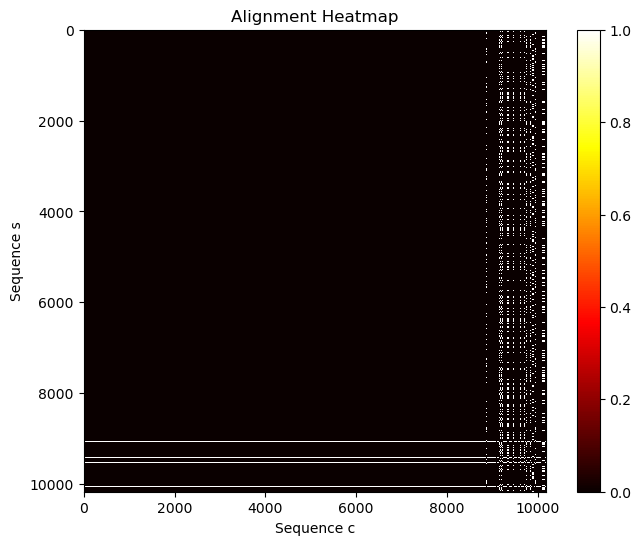

In [20]:
import numpy as np

# You already have the alignment score and sequences aligned

# Create a matrix for the alignment
alignment_matrix = np.zeros((len(s_aligned), len(c_aligned)))

# Assign match scores to the matrix
for i in range(len(s_aligned)):
    for j in range(len(c_aligned)):
        if s_aligned[i] == c_aligned[j]:
            alignment_matrix[i][j] = 1  # Assign 1 for match

# Plotting the alignment as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(alignment_matrix, cmap='hot', interpolation='nearest')

# Adding labels and title
plt.xlabel('Sequence c')
plt.ylabel('Sequence s')
plt.title('Alignment Heatmap')

# Show plot
plt.colorbar()
plt.show()


Alignment Score: 4.0


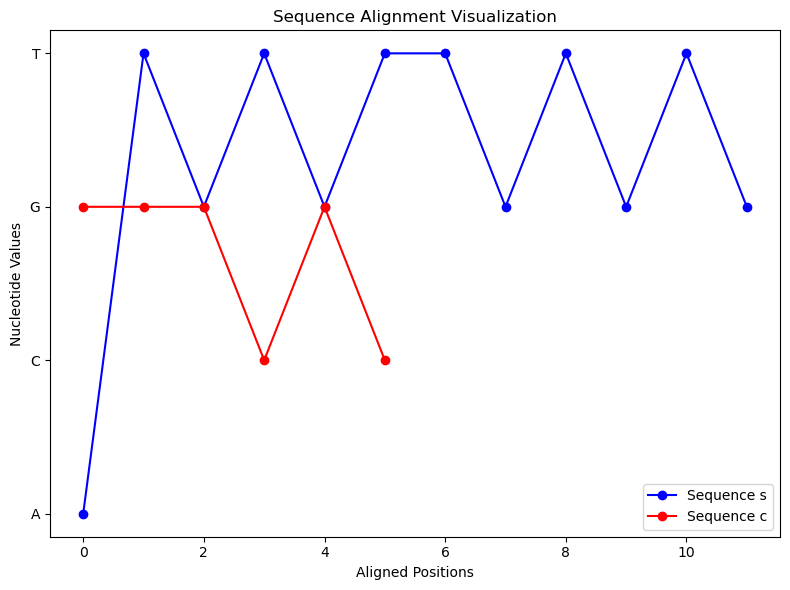

In [21]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import matplotlib.pyplot as plt

# Sequences
s1 = "atgtgt tgtgtg ..."  # Your long sequence here
s = s1.replace(" ", "")
c = "gggcgc"

# Align sequences
alignments = pairwise2.align.globalxx(s, c)

# Extract best alignment
best_alignment = alignments[0]

# Print alignment score
print(f"Alignment Score: {best_alignment.score}")

# Convert aligned sequences to numerical values for plotting
bases = {'a': 1, 'c': 2, 'g': 3, 't': 4}

s_aligned = best_alignment[0]
c_aligned = best_alignment[1]

s_numeric = [bases[base_s] for base_s in s_aligned if base_s in bases]
c_numeric = [bases[base_c] for base_c in c_aligned if base_c in bases]

# Plotting the aligned sequences
plt.figure(figsize=(8, 6))

# Plotting the sequences
plt.plot(range(len(s_numeric)), s_numeric, marker='o', linestyle='-', color='blue', label='Sequence s')
plt.plot(range(len(c_numeric)), c_numeric, marker='o', linestyle='-', color='red', label='Sequence c')

# Adding labels and title
plt.xlabel('Aligned Positions')
plt.ylabel('Nucleotide Values')
plt.title('Sequence Alignment Visualization')
plt.yticks([1, 2, 3, 4], ['A', 'C', 'G', 'T'])
plt.legend()

# Show plot
plt.tight_layout()
plt.show()



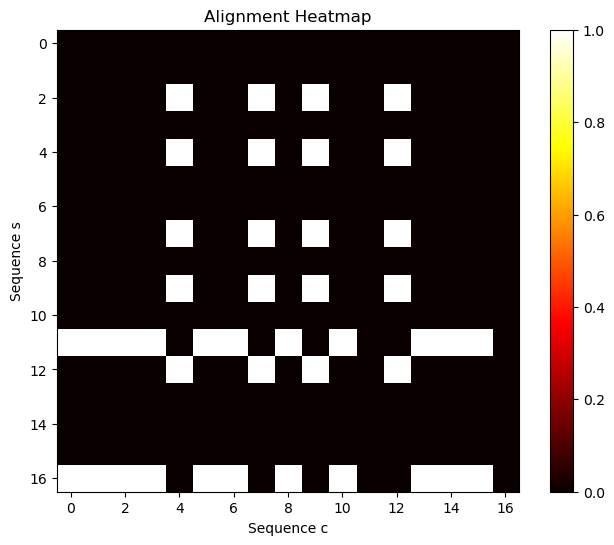

In [22]:
import numpy as np

# You already have the alignment score and sequences aligned

# Create a matrix for the alignment
alignment_matrix = np.zeros((len(s_aligned), len(c_aligned)))

# Assign match scores to the matrix
for i in range(len(s_aligned)):
    for j in range(len(c_aligned)):
        if s_aligned[i] == c_aligned[j]:
            alignment_matrix[i][j] = 1  # Assign 1 for match

# Plotting the alignment as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(alignment_matrix, cmap='hot', interpolation='nearest')

# Adding labels and title
plt.xlabel('Sequence c')
plt.ylabel('Sequence s')
plt.title('Alignment Heatmap')

# Show plot
plt.colorbar()
plt.show()